<a href="https://colab.research.google.com/github/buzzbing/transformer_based_source_code_generator/blob/main/ModelSPoCTrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install  'tensorflow-text==2.8.*'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import tensorflow as tf
import tensorflow_text as text

In [3]:
import collections
import os
import pathlib
import re
import string
import sys
import tempfile
import time

import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_text as text
import pandas as pd
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
import keras
import logging



In [4]:
import warnings
warnings.filterwarnings("ignore")

In [5]:
model_name = 'spoc_pseudocode_to_code_converter'

tokenizers = tf.saved_model.load('drive/MyDrive/MajorProjectPseudoCodeCpp/Tokenizer')
print(tokenizers.prob.get_vocab_size().numpy())
print(tokenizers.sol.get_vocab_size().numpy())

2201
1774


In [6]:
dataset = pd.read_csv("drive/MyDrive/MajorProjectPseudoCodeCpp/spoc_cleaned_next.csv")

In [7]:
test_examples = pd.read_csv("drive/MyDrive/MajorProjectPseudoCodeCpp/spoc_cleaned_testpB.csv")

In [8]:
dataset.sample(frac=1).reset_index(drop=True)
train_examples = dataset[2000:]
val_examples = dataset[:2000]

In [9]:
def domain_distribution(dataset):
    array_count= 0
    string_count= 0
    sort_count= 0
    arith_count=0
    ds_count = 0
    other_count = 0

    for each in dataset['pseudocode'].tolist():
        ac= re.findall('array',each)
        if ac: array_count +=1
        sc= re.findall('string',each)
        if sc: string_count +=1
        srtc = re.findall('sort',each)
        if srtc: sort_count+=1
        arc = re.findall('add|subtract|multiply|divide|factorial|sum|difference|product|mod|remainder|quotient|fibonacci',each)
        if arc: arith_count+=1
        temp = re.findall('linkedlist|stack|queue|list',each)
        if temp: ds_count+=1
            
    print("array count: ",array_count)
    print("string count: ",string_count)
    print("sort count: ",sort_count)
    print("arithmetic count: ",arith_count)
    print("data structure count: ",ds_count)
    

    dist_count = array_count+string_count+sort_count+arith_count+ds_count
    # print(dist_count)
    # others =len(dataset)-dist_count
    # print("others :" , others)
    
    print('\n'+'total: ',dist_count)
    y = np.array([array_count,string_count,sort_count,arith_count,ds_count])
    mylabels = ["Array", "String", "Sorting", "Arithmetic","Data Structures"]

    plt.pie(y, labels = mylabels)
    plt.show()

array count:  4292
string count:  3371
sort count:  1222
arithmetic count:  4471
data structure count:  112

total:  13468


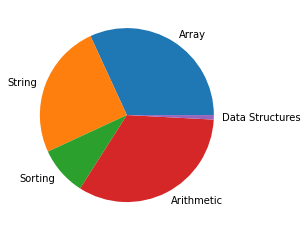

In [10]:
domain_distribution(dataset)

array count:  3627
string count:  2782
sort count:  1091
arithmetic count:  3985
data structure count:  98

total:  11583


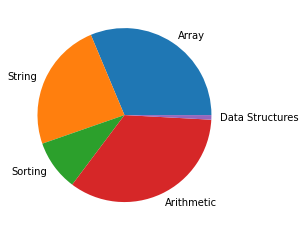

In [11]:
domain_distribution(train_examples)

array count:  665
string count:  589
sort count:  131
arithmetic count:  486
data structure count:  14

total:  1885


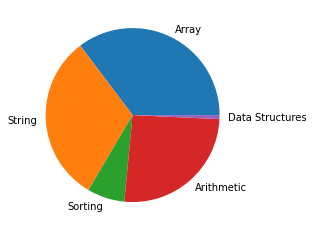

In [12]:
domain_distribution(val_examples)

array count:  682
string count:  493
sort count:  147
arithmetic count:  667
data structure count:  14

total:  2003


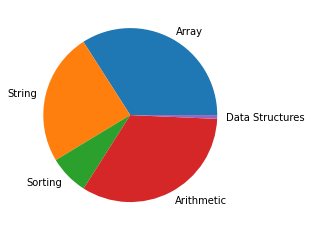

In [13]:
domain_distribution(test_examples)

In [14]:
test_examples.head

<bound method NDFrame.head of      QuestionID  SolutionID  \
0           20A    44242036   
1           20A    46375220   
2           20A    48384752   
3           20A    47795453   
4           20A    48893205   
...         ...         ...   
1772       156A    45105814   
1773      1023A    42364075   
1774       335A    47360505   
1775        51A    19554617   
1776       771A    40005180   

                                             pseudocode  \
0     declare short int sz\ndeclare boolean called f...   
1     let a be array of chars of length 110\nlen_._ ...   
2     set constant integer inf to 1000000010\nset co...   
3     declare string variable str\nread str\nans is ...   
4     s = string\nread s\ncreate integer t with valu...   
...                                                 ...   
1772  s = 1 = int\nwhile b is positive\nif b is odd ...   
1773  s_._ u are strings\nread s_._ u\nm is an integ...   
1774  la_._ lb are integers\ns and t are both charac...   
1775  f

In [15]:
test_examples = test_examples.drop(columns=['QuestionID','SolutionID'])

In [16]:
def dataset_to_tensor(data_examples,sep):
  data_prob = []
  for i in range(0,len(data_examples)):
    temp = str(data_examples.iloc[i,0])
    tempval = temp.replace(sep,',')
    data_prob.append(tempval)

  # inputs = data_examples['problem']
  print(data_prob[0])
  print(type(data_prob))

  data_sol = []
  for i in range(0,len(data_examples)):
    temp = str(data_examples.iloc[i,1])
    tempval = temp.replace(sep,',')
    data_sol.append(tempval)

  # inputs = data_examples['solution']
  print(data_sol[0])
  print(type(data_sol))

  tensor_prob = tf.convert_to_tensor(data_prob)
  tensor_sol = tf.convert_to_tensor(data_sol)

  tensor_data = tf.data.Dataset.from_tensor_slices((tensor_prob,tensor_sol))

  # tf.data.experimental.cardinality(tensor_data)
  return tensor_data, tensor_prob, tensor_sol;

In [17]:
val_data , prob_tensr, sol_tensr = dataset_to_tensor(val_examples,'_')
train_data, train_p, train_s = dataset_to_tensor(train_examples,'_')
test_data, test_p, test_s = dataset_to_tensor(test_examples,'_._')

if b=1 return a, else call function gcd(b, a%b)            n , nn, ans = integers with ans =0    Read n    for i=2 to n-1 execute    set nn to n    while nn is not equal to 0, set ans to ans + nn%i, and also set nn= nn/i        set o to gcd(ans, n-2)    print out ans/o "/" (n-2)/o            function gcd with integer arguments a and b    return !b ? a : gcd(b, a % b)            integers n, nn and ans = 0    read n    for i = 2 to n - 1 inclusive    set nn to n    while nn increment ans by (nn % i) and set nn to nn / i;        integer o = gcd of ans and n - 2    print ans / o, "/", (n - 2) / o and "\n"            
<class 'list'>
return !b ? a : gcd(b, a % b);    }    int main() {    int n, nn, ans = 0;    cin >> n;    for (int i = 2; i <= n - 1; ++i) {    nn = n;    while (nn) ans += nn % i, nn /= i;    }    int o = gcd(ans, n - 2);    cout << ans / o << "/" << (n - 2) / o << "\n";    return 0;    }    int gcd(int a, int b) {    return !b ? a : gcd(b, a % b);    }    int main() {    int

In [18]:
test_examples.iloc[0,0]

"declare short int sz\ndeclare boolean called flag = false\n\nread s\nfor integer i = length of s - 1 to 0 inclusive counting down\nif s[i] != '/'\nsz = i\nbreak the loop\n\n\nfor i = 0 to sz inclusive\nif flag = false and s[i] = '/'\nset flag to true\nprint s[i]\nelse if s[i] != '/'\nset flag to false\nprint s[i]\n\n\nprint '\\n'\n\n\n"

In [19]:
print(type(train_data))
print(type(test_data))
print(type(val_data))

<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>
<class 'tensorflow.python.data.ops.dataset_ops.TensorSliceDataset'>


In [20]:

MAX_TOKENS = 800

In [21]:
#  a function to drop the examples longer than MAX_TOKENS:
def filter_max_tokens(prob, sol):
  num_tokens = tf.maximum(tf.shape(prob)[1],tf.shape(sol)[1])
  return num_tokens < MAX_TOKENS

In [22]:
# a function that tokenizes the batches of raw text
def tokenize_pairs(prob, sol):
    prob = tokenizers.prob.tokenize(prob)
    # Convert from ragged to dense, padding with zeros.
    prob = prob.to_tensor()

    sol = tokenizers.sol.tokenize(sol)
    # Convert from ragged to dense, padding with zeros.
    sol = sol.to_tensor()
    return prob, sol

In [23]:
# input pipeline that processes, shuffles and batches the data

BUFFER_SIZE = 20000
BATCH_SIZE = 16

def make_batches(ds):
  return (
      ds
      .cache()
      .shuffle(BUFFER_SIZE)
      .batch(BATCH_SIZE)
      .map(tokenize_pairs, num_parallel_calls=tf.data.AUTOTUNE)
      .filter(filter_max_tokens)
      .prefetch(tf.data.AUTOTUNE))



In [24]:
train_batches = make_batches(train_data)

val_batches = make_batches(val_data)
test_batches = make_batches(test_data)

In [25]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

(1, 2048, 512)


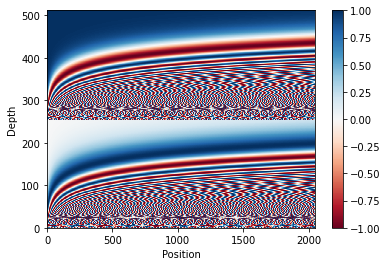

In [26]:
n, d = 2048, 512
pos_encoding = positional_encoding(n, d)
print(pos_encoding.shape)
pos_encoding = pos_encoding[0]

# Juggle the dimensions for the plot
pos_encoding = tf.reshape(pos_encoding, (n, d//2, 2))
pos_encoding = tf.transpose(pos_encoding, (2, 1, 0))
pos_encoding = tf.reshape(pos_encoding, (d, n))

plt.pcolormesh(pos_encoding, cmap='RdBu')
plt.ylabel('Depth')
plt.xlabel('Position')
plt.colorbar()
plt.show()

In [27]:
#Masking
# Mask all the pad tokens in the batch of sequence. 
# It ensures that the model does not treat padding as the input. 
# The mask indicates where pad value 0 is present:
#  it outputs a 1 at those locations, and a 0 otherwise.
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1

In [28]:
# The look-ahead mask is used to mask the future tokens in a sequence.
#  In other words, the mask indicates which entries should not be used.

# This means that to predict the third token, only the first and second token
#  will be used. Similarly to predict the fourth token, only the first,
#   second and the third tokens will be used and so on.

def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

In [29]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [30]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

In [31]:


# np.set_printoptions(suppress=True)

# temp_k = tf.constant([[10, 0, 0],
#                       [0, 10, 0],
#                       [0, 0, 10],
#                       [0, 0, 10]], dtype=tf.float32)  # (4, 3)

# temp_v = tf.constant([[1, 0],
#                       [10, 0],
#                       [100, 5],
#                       [1000, 6]], dtype=tf.float32)  # (4, 2)

# # This `query` aligns with the second `key`,
# # so the second `value` is returned.
# temp_q = tf.constant([[0, 10, 0]], dtype=tf.float32)  # (1, 3)
# print_out(temp_q, temp_k, temp_v)

In [32]:
class multiHeadAttention(keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(multiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = keras.layers.Dense(d_model)
    self.wk = keras.layers.Dense(d_model)
    self.wv = keras.layers.Dense(d_model)

    self.dense = keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

In [33]:
# temp_mha = multiHeadAttention(d_model=512, num_heads=8)
# y = tf.random.uniform((1, 60, 512))  # (batch_size, encoder_sequence, d_model)
# out, attn = temp_mha(y, k=y, q=y, mask=None)
# out.shape, attn.shape

In [34]:
def point_wise_feed_forward_network(d_model, dff):
  return keras.Sequential([
      keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [35]:
# sample_ffn = point_wise_feed_forward_network(512, 2048)
# sample_ffn(tf.random.uniform((64, 50, 512))).shape

In [36]:
class EncoderLayer(keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(EncoderLayer, self).__init__()

    self.mha = multiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = keras.layers.Dropout(rate)
    self.dropout2 = keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    attn_output, _ = self.mha(x, x, x, mask)  # (batch_size, input_seq_len, d_model)
    attn_output = self.dropout1(attn_output, training=training)
    out1 = self.layernorm1(x + attn_output)  # (batch_size, input_seq_len, d_model)

    ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
    ffn_output = self.dropout2(ffn_output, training=training)
    out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

    return out2

In [37]:
# sample_encoder_layer = EncoderLayer(d_model=512, num_heads=8, dff=2048)

# sample_encoder_layer_output = sample_encoder_layer(
#     tf.random.uniform((64, 43, 512)), False, None)

# sample_encoder_layer_output.shape  # (batch_size, input_seq_len, d_model)

In [38]:
class DecoderLayer(keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = multiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = multiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = keras.layers.Dropout(rate)
    self.dropout2 = keras.layers.Dropout(rate)
    self.dropout3 = keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    out1 = self.layernorm1(attn1 + x)

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, padding_mask)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [39]:
# sample_decoder_layer = DecoderLayer(d_model=512, num_heads=8, dff=2048)

# sample_decoder_layer_output, _, _ = sample_decoder_layer(
#     tf.random.uniform((64, 50, 512)), sample_encoder_layer_output,
#     False, None, None)

# sample_decoder_layer_output.shape  # (batch_size, target_seq_len, d_model)

In [40]:

#encoder consists of input embedding , positional encoding and n encoder layers

class Encoder(keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               rate=0.1):
    super(Encoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = keras.layers.Embedding(input_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, self.d_model)

    self.enc_layers = [
        EncoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]

    self.dropout = keras.layers.Dropout(rate)

  def call(self, x, training, mask):

    seq_len = tf.shape(x)[1]

    # adding embedding and position encoding.
    x = self.embedding(x)  # (batch_size, input_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x = self.enc_layers[i](x, training, mask)

    return x  # (batch_size, input_seq_len, d_model)

In [41]:
# sample_encoder = Encoder(num_layers=2, d_model=512, num_heads=8,
#                          dff=2048, input_vocab_size=8500)
# temp_input = tf.random.uniform((64, 62), dtype=tf.int64, minval=0, maxval=200)

# sample_encoder_output = sample_encoder(temp_input, training=False, mask=None)

# print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

In [42]:
class Decoder(keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers

    self.embedding = keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(MAX_TOKENS, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [43]:
# sample_decoder = Decoder(num_layers=2, d_model=512, num_heads=8,
#                          dff=2048, target_vocab_size=8000)
# temp_input = tf.random.uniform((64, 26), dtype=tf.int64, minval=0, maxval=200)

# output, attn = sample_decoder(temp_input,
#                               enc_output=sample_encoder_output,
#                               training=False,
#                               look_ahead_mask=None,
#                               padding_mask=None)

# output.shape, attn['decoder_layer2_block2'].shape

In [44]:
class Transformer(keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff, input_vocab_size,
               target_vocab_size, rate=0.1):
    super().__init__()
    self.encoder = Encoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           input_vocab_size=input_vocab_size, rate=rate)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, rate=rate)

    self.final_layer = keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    inp, tar = inputs

    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    enc_output = self.encoder(inp, training, padding_mask)  # (batch_size, inp_seq_len, d_model)

    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [45]:
# sample_transformer = Transformer(
#     num_layers=2, d_model=512, num_heads=8, dff=2048,
#     input_vocab_size=8500, target_vocab_size=8000)

# temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
# temp_target = tf.random.uniform((64, 36), dtype=tf.int64, minval=0, maxval=200)

# fn_out, _ = sample_transformer([temp_input, temp_target], training=False)

# fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

In [46]:
# hyperparameters
num_layers = 4
d_model = 128
dff = 512
num_heads = 8
dropout_rate = 0.1

In [47]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

In [48]:
learning_rate = CustomSchedule(d_model)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-3)

Text(0.5, 0, 'Train Step')

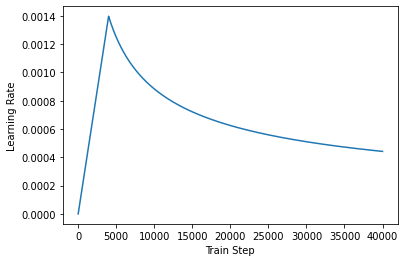

In [49]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

In [50]:
loss_object = keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [51]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [52]:
train_loss = keras.metrics.Mean(name='train_loss')
train_accuracy = keras.metrics.Mean(name='train_accuracy')
validation_loss = keras.metrics.Mean(name='validation_loss')
validation_accuracy = keras.metrics.Mean(name='validation_accuracy')
test_loss = keras.metrics.Mean(name='test_loss')
test_accuracy = keras.metrics.Mean(name='test_accuracy')

In [53]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    input_vocab_size=tokenizers.prob.get_vocab_size().numpy(),
    target_vocab_size=tokenizers.sol.get_vocab_size().numpy(),
    rate=dropout_rate)

In [54]:
EPOCHS = 100

In [55]:
print(len(train_examples))

12547


In [56]:
# The @tf.function trace-compiles train_step into a TF graph for faster
# execution. The function specializes to the precise shape of the argument
# tensors. To avoid re-tracing due to the variable sequence lengths or variable
# batch sizes (the last batch is smaller), use input_signature to specify
# more generic shapes.

train_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature=train_step_signature)
def train_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = True)
    loss = loss_function(tar_real, predictions)

  gradients = tape.gradient(loss, transformer.trainable_variables)
  optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

  train_loss(loss)
  train_accuracy(accuracy_function(tar_real, predictions))

In [57]:
# print(

In [58]:
# from tensorflow.python.ops.numpy_ops import np_config
# np_config.enable_numpy_behavior()

val_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]


@tf.function(input_signature= val_step_signature)
def val_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = False)
    loss = loss_function(tar_real, predictions)

  validation_loss(loss)
  validation_accuracy(accuracy_function(tar_real, predictions))



test_step_signature = [
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
    tf.TensorSpec(shape=(None, None), dtype=tf.int64),
]

@tf.function(input_signature=test_step_signature)
def test_step(inp, tar):
  tar_inp = tar[:, :-1]
  tar_real = tar[:, 1:]

  with tf.GradientTape() as tape:
    predictions, _ = transformer([inp, tar_inp],
                                 training = False)
    loss = loss_function(tar_real, predictions)

  test_loss(loss)
  test_accuracy(accuracy_function(tar_real, predictions))

In [59]:
e_list =[]
acc_list = []
loss_list = []
val_acc_list = []
val_loss_list = []
test_acc_list = []
test_loss_list = []

In [60]:

for epoch in range(EPOCHS):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> problem pseudocode, tar -> solution in c++
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

#   if (epoch + 1) % 5 == 0:
#     # ckpt_save_path = ckpt_manager.save()
#     print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')
  e_list.append(epoch+1)
  loss_list.append(train_loss.result())
  acc_list.append(train_accuracy.result())
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  validation_loss.reset_states()
  validation_accuracy.reset_states()
  start = time.time()
  # inp -> problem pseudocode, tar -> solution in c++
  for (batch, (inp, tar)) in enumerate(val_batches):
    val_step(inp, tar)


  print(f'Epoch {epoch + 1} Loss {validation_loss.result():.4f} Accuracy {validation_accuracy.result():.4f}')
  
  val_loss_list.append(validation_loss.result())
  val_acc_list.append(validation_accuracy.result())
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

  test_loss.reset_states()
  test_accuracy.reset_states()
  start = time.time()
  # inp -> problem pseudocode, tar -> solution in c++
  for (batch, (inp, tar)) in enumerate(test_batches):
    test_step(inp, tar)


  print(f'Epoch {epoch + 1} Loss {test_loss.result():.4f} Accuracy {test_accuracy.result():.4f}')
  
  test_loss_list.append(test_loss.result())
  test_acc_list.append(test_accuracy.result())
  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')
  


Epoch 1 Batch 0 Loss 7.6589 Accuracy 0.0000
Epoch 1 Batch 50 Loss 7.5558 Accuracy 0.0003
Epoch 1 Batch 100 Loss 7.3218 Accuracy 0.0310
Epoch 1 Batch 150 Loss 7.1091 Accuracy 0.0508
Epoch 1 Batch 200 Loss 6.9159 Accuracy 0.0609
Epoch 1 Batch 250 Loss 6.7176 Accuracy 0.0670
Epoch 1 Batch 300 Loss 6.5037 Accuracy 0.0712
Epoch 1 Batch 350 Loss 6.2828 Accuracy 0.0743
Epoch 1 Batch 400 Loss 6.0667 Accuracy 0.0768
Epoch 1 Batch 450 Loss 5.8714 Accuracy 0.0796
Epoch 1 Batch 500 Loss 5.7018 Accuracy 0.0841
Epoch 1 Batch 550 Loss 5.5412 Accuracy 0.0940
Epoch 1 Batch 600 Loss 5.3848 Accuracy 0.1075
Epoch 1 Batch 650 Loss 5.2329 Accuracy 0.1220
Epoch 1 Batch 700 Loss 5.0854 Accuracy 0.1364
Epoch 1 Batch 750 Loss 4.9461 Accuracy 0.1505
Epoch 1 Loss 4.8960 Accuracy 0.1558
Time taken for 1 epoch: 145.87 secs

Epoch 1 Loss 2.9563 Accuracy 0.3528
Time taken for 1 epoch: 14.55 secs

Epoch 1 Loss 3.1384 Accuracy 0.3340
Time taken for 1 epoch: 15.93 secs

Epoch 2 Batch 0 Loss 2.8479 Accuracy 0.3606
Epoch 

KeyboardInterrupt: ignored

In [61]:
print(len(acc_list))
print(len(e_list))
print(len(val_acc_list))
print(len(test_acc_list))

80
80
80
80


In [ ]:
print(

In [62]:
def check_null(a_list):
    temp = np.array(a_list)
    index, = np.where(temp == 0.0000)
  # if (x == 0.0000): print(x.index())
    print(index)

check_null(val_acc_list)
check_null(val_loss_list)
check_null(test_acc_list)
check_null(test_loss_list)

[]
[]
[]
[]


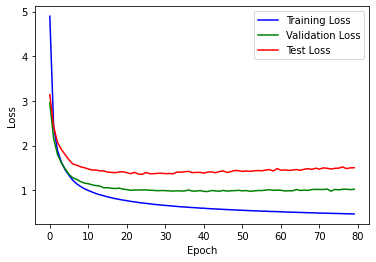

In [63]:
# plot of accuracy and loss of training data
# e_list =[]
# acc_list = []


xptt_loss = np.array(range(len(loss_list)))
yptt_loss = np.array(loss_list)

plt.plot(xptt_loss, yptt_loss,color = 'b', label = 'Training Loss')

zpoints = np.array(val_loss_list)
plt.plot(xptt_loss, zpoints,color = 'g', label = 'Validation Loss')

qpoints = np.array(test_loss_list)
plt.plot(xptt_loss, qpoints,color = 'r', label = 'Test Loss')

plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.legend()
plt.show()

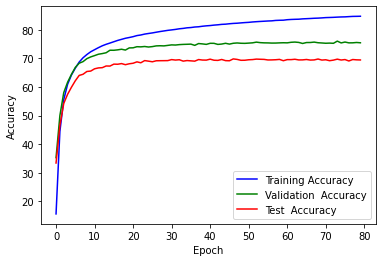

In [65]:
xp_ep= np.array(range(len(acc_list)))
yp_tacc = np.array(acc_list)*100


zp_vacc = np.array(val_acc_list)*100
zp_test = np.array(test_acc_list)*100

plt.plot(xp_ep, yp_tacc,color = 'b',label = 'Training Accuracy')
plt.plot(xp_ep, zp_vacc,color = 'g',label = 'Validation  Accuracy')
plt.plot(xp_ep, zp_test,color = 'r',label = 'Test  Accuracy')

plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [66]:
# @keras.utils.generic_utils.register_keras_serializable
class Translator(tf.Module):
  # Translator.__name__ = 'Translator'
  def __init__(self, tokenizers, transformer):
    self.tokenizers = tokenizers
    self.transformer = transformer

  def __call__(self, sentence, max_length=MAX_TOKENS):
    # input sentence is problem statement, hence adding the start and end token
    assert isinstance(sentence, tf.Tensor)
    if len(sentence.shape) == 0:
      sentence = sentence[tf.newaxis]

    sentence = self.tokenizers.prob.tokenize(sentence).to_tensor()

    encoder_input = sentence

    # As the output language is cpp program, initialize the output with the
    # english start token.
    start_end = self.tokenizers.sol.tokenize([''])[0]
    start = start_end[0][tf.newaxis]
    end = start_end[1][tf.newaxis]

    # `tf.TensorArray` is required here (instead of a python list) so that the
    # dynamic-loop can be traced by `tf.function`.
    output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
    output_array = output_array.write(0, start)

    for i in tf.range(max_length):
      output = tf.transpose(output_array.stack())
      predictions, _ = self.transformer([encoder_input, output], training=False)

      # select the last token from the seq_len dimension
      predictions = predictions[:, -1:, :]  # (batch_size, 1, vocab_size)

      predicted_id = tf.argmax(predictions, axis=-1)

      # concatentate the predicted_id to the output which is given to the decoder
      # as its input.
      output_array = output_array.write(i+1, predicted_id[0])

      if predicted_id == end:
        break

    output = tf.transpose(output_array.stack())
    # output.shape (1, tokens)
    text = tokenizers.sol.detokenize(output)[0]  # shape: ()

    tokens = tokenizers.sol.lookup(output)[0]

    # `tf.function` prevents us from using the attention_weights that were
    # calculated on the last iteration of the loop. So recalculate them outside
    # the loop.
    _, attention_weights = self.transformer([encoder_input, output[:,:-1]], training=False)

    return text, tokens, attention_weights

In [67]:

# with custom_object_scope({'my_t': my_t}):
translator = Translator(tokenizers, transformer)

In [68]:
def print_translation(sentence, tokens, ground_truth):
  print(f'{"Input:":15s}: {sentence}')

  print("\n\n")
  print(f'{"Prediction":15s}: {tokens.numpy().decode("utf-8")}')
  print("\n\n")
  print(f'{"Ground truth":15s}: {ground_truth}')
  
  print("\n\n")

In [69]:
sentence = 'create map iterator it from string to integer    create integer n    read n    read character    for i = 0 to n exclusive    create sting str    read line from cin to str    set m[str] to 1    create integer ans with ans = 0    for it = beginning of m to it is not end of m, incrementing it, increment ans    print ans print newline    '
ground_truth = 'map<string, int>::iterator it;    int main() {    int n;    cin >> n;    getchar();    for (int i = 0; i < n; i++) {    string str;    getline(cin, str);    m[str] = 1;    }    int ans = 0;    for (it = m.begin(); it != m.end(); it++) { ans++; }    cout << ans << endl;    }    '

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : create map iterator it from string to integer    create integer n    read n    read character    for i = 0 to n exclusive    create sting str    read line from cin to str    set m[str] to 1    create integer ans with ans = 0    for it = beginning of m to it is not end of m, incrementing it, increment ans    print ans print newline    



Prediction     : int n ; string s ; cin > > n > > s ; map < char , int > m ; for ( int i = 0 ; i < n ; i + + ) { cin > > s ; m [ s ] + + ; } int ans = 0 ; for ( int i = 1 ; i < = 26 ; i + + ) { if ( m [ i ] = = 0 ) { ans + + ; } } cout < < ans < < endl ; return 0 ; }



Ground truth   : map<string, int>::iterator it;    int main() {    int n;    cin >> n;    getchar();    for (int i = 0; i < n; i++) {    string str;    getline(cin, str);    m[str] = 1;    }    int ans = 0;    for (it = m.begin(); it != m.end(); it++) { ans++; }    cout << ans << endl;    }    





In [70]:
sentence = 'let t an int      read t      while postdecrement t      let s a string      read s      if size of s at most 10      print s      continue      otherwise      print s[0], followed by size of s less 2, followed by s[size of s less 1]      '
ground_truth = 'int n, m, i, j, pos = 0;      cin >> n >> m;      int c[n], a[m];      for (i = 0; i < n; i++) { cin >> c[i]; }      for (j = 0; j < m; j++) { cin >> a[j]; }      for (i = 0; i < n; i++) {      if (pos < m) {      if (a[pos] >= c[i]) {      pos = pos + 1;      } else {      continue;      }      }      }      cout << pos << endl;      return 0;      }      '

translated_text, translated_tokens, attention_weights = translator(
    tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : let t an int      read t      while postdecrement t      let s a string      read s      if size of s at most 10      print s      continue      otherwise      print s[0], followed by size of s less 2, followed by s[size of s less 1]      



Prediction     : int t ; cin > > t ; while ( t - - ) { string s ; cin > > s ; if ( s . size ( ) < = 10 ) cout < < s < < endl ; else { cout < < s [ 0 ] < < s . size ( ) - 2 < < s [ s . size ( ) - 1 ] < < endl ; } } return 0 ; }



Ground truth   : int n, m, i, j, pos = 0;      cin >> n >> m;      int c[n], a[m];      for (i = 0; i < n; i++) { cin >> c[i]; }      for (j = 0; j < m; j++) { cin >> a[j]; }      for (i = 0; i < n; i++) {      if (pos < m) {      if (a[pos] >= c[i]) {      pos = pos + 1;      } else {      continue;      }      }      }      cout << pos << endl;      return 0;      }      





In [71]:
sentence = 'declare integers num1, num2     input num1,num2      product = num1*num2     print product'
ground_truth = 'int main()   {int num1,num2;   cin>>num1>>num2;   product = num1*num2  ;   cout<<product;   return 0;}'

translated_text, translated_tokens, attention_weights = translator( tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : declare integers num1, num2     input num1,num2      product = num1*num2     print product



Prediction     : long long int n , k ; cin > > n > > k ; cout < < 1ll * ( long long int ) floor ( sqrt ( tp ) ) < < endl ; return 0 ; }



Ground truth   : int main()   {int num1,num2;   cin>>num1>>num2;   product = num1*num2  ;   cout<<product;   return 0;}





In [72]:
sentence = 'declare integers num1    take input num1, num2    print num1+ num2'
ground_truth = 'int main() { int num1;    cin>>num1>>num2 ;   cout<<num1+num2;    return 0;}'

translated_text, translated_tokens, attention_weights = translator( tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : declare integers num1    take input num1, num2    print num1+ num2



Prediction     : int main ( ) { cin > > s > > num1 ; cout < < num1 + num2 < < endl ; }



Ground truth   : int main() { int num1;    cin>>num1>>num2 ;   cout<<num1+num2;    return 0;}





In [73]:
sentence = 'declare integer a   input a   print a '
ground_truth = 'int main(){ int a;  cin>> a;  cout<<a;   return 0;}'

translated_text, translated_tokens, attention_weights = translator( tf.constant(sentence))
print_translation(sentence, translated_text, ground_truth)

Input:         : declare integer a   input a   print a 



Prediction     : int a ; cin > > a ; cout < < a < < endl ; return 0 ; }



Ground truth   : int main(){ int a;  cin>> a;  cout<<a;   return 0;}





In [74]:
def plot_attention_head(in_tokens, translated_tokens, attention):
  # The plot is of the attention when a token was generated.
  # The model didn't generate `<START>` in the output. Skip it.
  translated_tokens = translated_tokens[1:]

  ax = plt.gca()
  ax.matshow(attention)
  ax.set_xticks(range(len(in_tokens)))
  ax.set_yticks(range(len(translated_tokens)))

  labels = [label.decode('utf-8') for label in in_tokens.numpy()]
  ax.set_xticklabels(
      labels, rotation=90)

  labels = [label.decode('utf-8') for label in translated_tokens.numpy()]
  ax.set_yticklabels(labels)

In [75]:
head = 0
# shape: (batch=1, num_heads, seq_len_q, seq_len_k)
attention_heads = tf.squeeze(
  attention_weights['decoder_layer4_block2'], 0)
attention = attention_heads[head]
attention.shape

TensorShape([21, 9])

In [76]:
in_tokens = tf.convert_to_tensor([sentence])
in_tokens = tokenizers.prob.tokenize(in_tokens).to_tensor()
in_tokens = tokenizers.prob.lookup(in_tokens)[0]
in_tokens

<tf.Tensor: shape=(9,), dtype=string, numpy=
array([b'[START]', b'declare', b'integer', b'a', b'input', b'a', b'print',
       b'a', b'[END]'], dtype=object)>

In [77]:
translated_tokens

<tf.Tensor: shape=(22,), dtype=string, numpy=
array([b'[START]', b'int', b'a', b';', b'cin', b'>', b'>', b'a', b';',
       b'cout', b'<', b'<', b'a', b'<', b'<', b'endl', b';', b'return',
       b'0', b';', b'}', b'[END]'], dtype=object)>

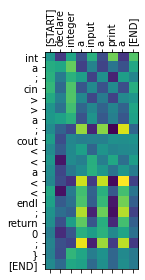

In [78]:
plot_attention_head(in_tokens, translated_tokens, attention)

In [79]:
def plot_attention_weights(sentence, translated_tokens, attention_heads):
  in_tokens = tf.convert_to_tensor([sentence])
  in_tokens = tokenizers.prob.tokenize(in_tokens).to_tensor()
  in_tokens = tokenizers.prob.lookup(in_tokens)[0]
  in_tokens

  fig = plt.figure(figsize=(16, 8))

  for h, head in enumerate(attention_heads):
    ax = fig.add_subplot(2, 4, h+1)

    plot_attention_head(in_tokens, translated_tokens, head)

    ax.set_xlabel(f'Head {h+1}')

  plt.tight_layout()
  plt.show()

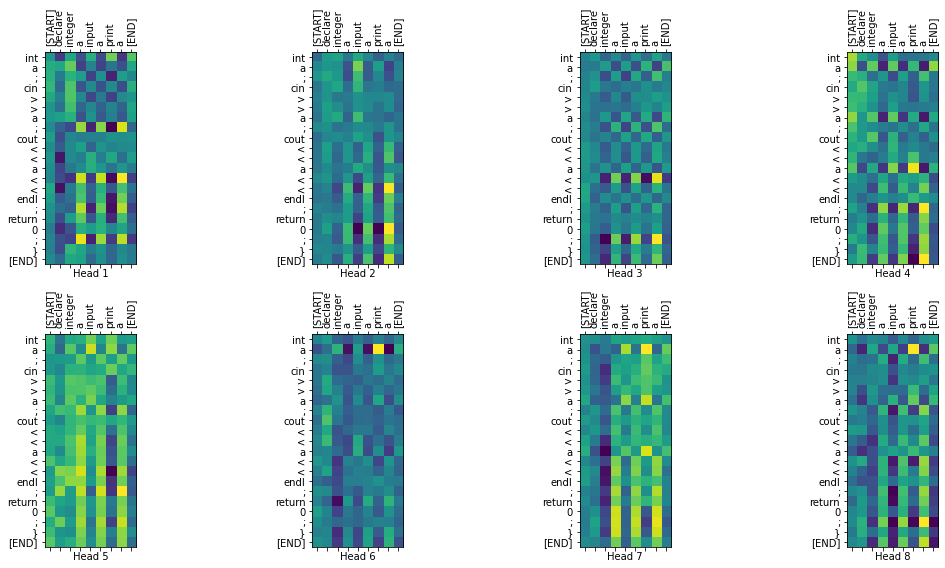

In [80]:
plot_attention_weights(sentence, translated_tokens,
                       attention_weights['decoder_layer4_block2'][0])

In [81]:

class ExportTranslator(tf.Module):
#   ExportTranslator.__name__ = 'ExportTranslator'
  def __init__(self, translator):
    self.translator = translator

  @tf.function(input_signature=[tf.TensorSpec(shape=[], dtype=tf.string)])
  def __call__(self, sentence):
    (result,
     tokens,
     attention_weights) = self.translator(sentence, max_length=MAX_TOKENS)

    return result

In [82]:
translator = ExportTranslator(translator)

In [83]:
translator('declare int a').numpy()

b'int a ; cin > > a ; int ans = a ; cout < < " 25 " < < endl ; }'

In [84]:
tf.saved_model.save(translator, export_dir='drive/MyDrive/MajorProjectPseudoCodeCpp/PseudocodeModel')

In [85]:
model_t = tf.saved_model.load('drive/MyDrive/MajorProjectPseudoCodeCpp/PseudocodeModel')

In [86]:
model_t('''
declare integer variable A, B, C,n
take input n
Set A = 0, B = 0
DISPLAY A, B
for n times
  C = A + B
  DISPLAY C
  Set A = B, B = C''').numpy()

b'int a , b , c = 0 , n = 0 ; cin > > a > > b ; for ( int i = 0 ; i < a ; i + + ) { cin > > n ; c + = b ; } cout < < c < < endl ; return 0 ; }'

In [87]:
model_t('declare integer a   input a   print a ').numpy()

b'int a ; cin > > a ; cout < < a < < endl ; return 0 ; }'